## Reading Data in Medical Imaging
In medical imaging the data io is one of the most challenging steps. In this example we explore the different options for reading image and feeding them to Tensorflow.

* Generators: use native python generator functions

* Feeding: Python code provides the data when running each step

* TFRecord: record-oriented file format to process large datasets that do not fit in memory

Below you may find benchmarks for feed dictionaries, numpy generators and TFRecord

### Timer helper class

In [1]:
import time

class Timer(object):
    """Timer class
       Wrap a will with a timing function
    """
    
    def __init__(self, name):
        self.name = name
        
    def __enter__(self):
        self.t = time.time()
        
    def __exit__(self, *args, **kwargs):
        print("{} took {} seconds".format(
        self.name, time.time() - self.t))

### Necessary imports

In [2]:
import SimpleITK as sitk
import os
from dltk.io.augmentation import *
from dltk.io.preprocessing import *
import tensorflow as tf

# Use pandas to read csvs
import pandas as pd
import tensorflow as tf

In [3]:
# Define the batch size for all examples and number of iterations
batch_size = 5
iterations = 100

all_filenames = pd.read_csv(
    '../../data/IXI_HH/demographic_HH.csv',
    dtype=object,
    keep_default_na=False,
    na_values=[]).as_matrix()

# Keep the first 10 images
all_filenames = all_filenames[:10]

# Define the desired shapes of the examples and parameters to pass to `read_fn`:
reader_params = {'n_examples': 1,
                 'example_size': [128, 224, 224],
                 'extract_examples': True}

reader_example_shapes = {'features': {'x': reader_params['example_size'] + [1,]},
                         'labels': {'y': []}}

# Here, we would like to train our features and use labels as targets: 
reader_example_dtypes = {'features': {'x': tf.float32},
                         'labels': {'y': tf.int32}}

### Using generators

In [4]:
def read_fn(file_references, mode, params=None):
    
    # We define a `read_fn` and iterate through the `file_references`, which
    # can contain information about the data to be read (e.g. a file path):
    for meta_data in file_references:
        
        # Here, we parse the `subject_id` to construct a file path to read
        # an image from.
        subject_id = meta_data[0]
        data_path = '../../data/IXI_HH/1mm'
        t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))
        
        # Read the .nii image containing a brain volume with SimpleITK and get 
        # the numpy array:
        sitk_t1 = sitk.ReadImage(t1_fn)
        t1 = sitk.GetArrayFromImage(sitk_t1)

        # Normalise the image to zero mean/unit std dev:
        t1 = whitening(t1)
        
        # Create a 4D Tensor with a dummy dimension for channels
        t1 = t1[..., np.newaxis]
        
        # If in PREDICT mode, yield the image (because there will be no label
        # present). Additionally, yield the sitk.Image pointer (including all
        # the header information) and some metadata (e.g. the subject id),
        # to facilitate post-processing (e.g. reslicing) and saving.
        # This can be useful when you want to use the same read function as 
        # python generator for deployment.
        if mode == tf.estimator.ModeKeys.PREDICT:
            yield {'features': {'x': t1}}

        # Labels: Here, we parse the class *sex* from the file_references 
        # \in [1,2] and shift them to \in [0,1] for training:
        sex = np.int32(meta_data[1]) - 1
        y = sex
        
        # If training should be done on image patches for improved mixing, 
        # memory limitations or class balancing, call a patch extractor
        if params['extract_examples']:
            images = extract_random_example_array(
                t1,
                example_size=params['example_size'],
                n_examples=params['n_examples'])
            
            # Loop the extracted image patches and yield
            for e in range(params['n_examples']):
                yield {'features': {'x': images[e].astype(np.float32)},
                       'labels': {'y': y.astype(np.int32)}}
                     
        # If desired (i.e. for evaluation, etc.), return the full images
        else:
            yield {'features': {'x': images},
                   'labels': {'y': y.astype(np.int32)}}

    return

In [5]:
# Generator function
def f():
    fn = read_fn(file_references=all_filenames,
                 mode=tf.estimator.ModeKeys.TRAIN, 
                 params=reader_params)
    
    ex = next(fn)
    # Yield the next image
    yield ex
    
# Timed example with generator io
dataset = tf.data.Dataset.from_generator(
    f, reader_example_dtypes, reader_example_shapes)
dataset = dataset.repeat(None)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)

iterator = dataset.make_initializable_iterator()
next_dict = iterator.get_next()

with tf.train.MonitoredTrainingSession() as sess_gen:
    # Initialize generator
    sess_gen.run(iterator.initializer)

    with Timer('Generator'):
        for i in range(iterations):
            # Fetch the next batch of images
            gen_batch_feat, gen_batch_lbl = sess_gen.run([next_dict['features'], next_dict['labels']])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Generator took 107.3727617263794 seconds


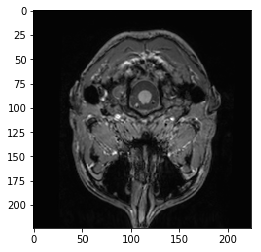

In [6]:
# Visualise the `gen_batch_feat` using matplotlib.
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(gen_batch_feat['x'][3, 0, :, :, 0], 'gray')
plt.show()

### Using feed dictionaries

In [7]:
def load_data(file_references, mode, params=None):
    
    data = {'features': [], 'labels': []}
    
    # We define a `read_fn` and iterate through the `file_references`, which
    # can contain information about the data to be read (e.g. a file path):
    for meta_data in file_references:
        
        # Here, we parse the `subject_id` to construct a file path to read
        # an image from.
        subject_id = meta_data[0]
        data_path = '../../data/IXI_HH/1mm'
        t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))
        
        # Read the .nii image containing a brain volume with SimpleITK and get 
        # the numpy array:
        sitk_t1 = sitk.ReadImage(t1_fn)
        t1 = sitk.GetArrayFromImage(sitk_t1)

        # Normalise the image to zero mean/unit std dev:
        t1 = whitening(t1)
        
        # Create a 4D Tensor with a dummy dimension for channels
        t1 = t1[..., np.newaxis]

        # Labels: Here, we parse the class *sex* from the file_references 
        # \in [1,2] and shift them to \in [0,1] for training:
        sex = np.int32(meta_data[1]) - 1
        y = sex
        
        # If training should be done on image patches for improved mixing, 
        # memory limitations or class balancing, call a patch extractor
        if params['extract_examples']:
            images = extract_random_example_array(
                t1,
                example_size=params['example_size'],
                n_examples=params['n_examples'])
            
            # Loop the extracted image patches
            for e in range(params['n_examples']):
                data['features'].append(images[e].astype(np.float32))
                data['labels'].append(y.astype(np.int32))
                     
        # If desired (i.e. for evaluation, etc.), return the full images
        else:
            data['features'].append(images)
            data['labels'].append(y.astype(np.int32))

    data['features'] = np.array(data['features'])
    data['labels'] = np.vstack(data['labels'])
            
    return data

In [8]:
# Load all data into memory
data = load_data(all_filenames, 
                 tf.estimator.ModeKeys.TRAIN, reader_params)

x = tf.placeholder(reader_example_dtypes['features']['x'], 
                   [None, 128, 224, 224, 1])
y = tf.placeholder(reader_example_dtypes['labels']['y'], 
                   [None, 1])

dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.repeat(None)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)

features = data['features']
labels = data['labels']
# Check that features and labels dimensions match
assert features.shape[0] == labels.shape[0]

iterator = dataset.make_initializable_iterator()
nx = iterator.get_next()

with tf.train.MonitoredTrainingSession() as sess_dict:
    # Initialize iterator
    sess_dict.run(iterator.initializer, 
               feed_dict={x: features, y: labels})
    
    with Timer('Feed dictionary'):
        # Timed feed dictionary example
        for i in range(iterations):
            # Get next features-labels pair
            dict_batch_feat, dict_batch_lbl = sess_dict.run(nx)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Feed dictionary took 5.658488988876343 seconds


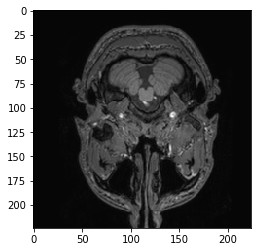

In [9]:
# Visualise the `dict_batch_feat` using matplotlib.
plt.imshow(dict_batch_feat[3, 0, :, :, 0], 'gray')
plt.show()

### Using TFRecord

Load data for a single subject

In [10]:
def load_img(meta_data, params):
    x = []
    
    # Here, we parse the `subject_id` to construct a file path to read
    # an image from.
    subject_id = meta_data[0]
    data_path = '../../data/IXI_HH/1mm'
    t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))

    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    sitk_t1 = sitk.ReadImage(t1_fn)
    t1 = sitk.GetArrayFromImage(sitk_t1)

    # Normalise the image to zero mean/unit std dev:
    t1 = whitening(t1)
    
    # Create a 4D Tensor with a dummy dimension for channels
    t1 = t1[..., np.newaxis]

    # Labels: Here, we parse the class *sex* from the file_references 
    # \in [1,2] and shift them to \in [0,1] for training:
    sex = np.int32(meta_data[1]) - 1
    y = sex
    
    # If training should be done on image patches for improved mixing, 
    # memory limitations or class balancing, call a patch extractor
    if params['extract_examples']:
        images = extract_random_example_array(
            t1,
            example_size=params['example_size'],
            n_examples=params['n_examples'])

        # Loop the extracted image patches and yield
        for e in range(params['n_examples']):
            x.append(images[e].astype(np.float32))

    # If desired (i.e. for evaluation, etc.), return the full images
    else:
        x = images
            
    return np.array(x), y  

Convert data to features

In [11]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    # Since this will be used to convert an np.array we don't use []
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

Write data into a TFRecords file

In [12]:
train_filename = 'train.tfrecords'  # address to save the TFRecords file
# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)

for meta_data in all_filenames:
    # Load the image
    img, label = load_img(meta_data, reader_params)
    # Create a feature
    feature = {'train/label': _int64_feature(label),
               'train/image': _float_feature(img.ravel())}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()

Load TFRecord and decode data

In [13]:
def decode(serialized_example):
    # Decode examples stored in TFRecord
    # NOTE: make sure to specify the correct dimensions for the images
    features = tf.parse_single_example(
        serialized_example,
        features={'train/image': tf.FixedLenFeature([128, 224, 224, 1], tf.float32),
                  'train/label': tf.FixedLenFeature([], tf.int64)})

    # NOTE: No need to cast these features, as they are already `tf.float32` values.
    return features['train/image'], features['train/label']

dataset = tf.data.TFRecordDataset(train_filename).map(decode)
dataset = dataset.repeat(None)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)

iterator = dataset.make_initializable_iterator()
features, labels = iterator.get_next()
nx = iterator.get_next()

with tf.train.MonitoredTrainingSession() as sess_rec:
    sess_rec.run(iterator.initializer)

    with Timer('TFRecord'):
        # Time TFRecord io
        for i in range(iterations):
            try:
                # Get next features-labels pair
                rec_batch_feat, rec_batch_lbl = sess_rec.run([features, labels])
                
            except tf.errors.OutOfRangeError:
                # Raised when we reach the end of the file.
                pass

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
TFRecord took 29.566031217575073 seconds


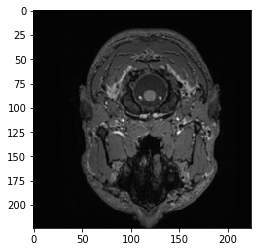

In [14]:
# Visualise the `rec_batch_feat` using matplotlib.
plt.imshow(rec_batch_feat[3, 0, :, :, 0], 'gray')
plt.show()